## Prepare Environments

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [ ]:
import os, sys, shutil
import torch

PYTHON = f"{sys.version_info.major}.{sys.version_info.minor}"

TORCH_version = torch.__version__
TORCH = TORCH_version.split('+')[0]

CUDA_version = torch.version.cuda
CUDA = 'cu' + CUDA_version.replace('.', '')

print(PYTHON,TORCH,CUDA)

3.10 2.0.1 cu118


In [ ]:
os.system("pip install 'igfold>=0.3.0'")
os.system("pip install --no-warn-conflicts 'py3Dmol>=2.0.1' matplotlib seaborn")
# taking ~ 3min

0

In [ ]:
os.system(f"conda install -y -c conda-forge openmm=7.7.0 python='{PYTHON}' pdbfixer 2>&1 1>/dev/null")
os.system(f"conda install -y -c bioconda abnumber hmmer biopython python='{PYTHON}' 2>&1 1>/dev/null")
# taking ~ 5min

0

In [ ]:
os.system(f"pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html")
os.system(f"pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html")
os.system(f"pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html")
os.system(f"pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html")

os.system(f"git clone https://github.com/oxpig/SCALOP.git")
os.system(f"pip install SCALOP/")
shutil.rmtree('SCALOP')

## Prepare codes

In [ ]:
import os, sys, shutil
if not os.path.isdir("models"):
    os.system('git clone https://github.com/songjie-guo/antibody-design.git')
    shutil.move('antibody-design/models', 'models')
    # shutil.move('antibody-design/environment.yml','environment.yml')
    # shutil.rmtree('antibody-design')

if not os.path.isdir("models/ProDesign"):
    os.chdir('./models')
    os.system("git clone -q https://github.com/A4Bio/ProDesign.git")
    os.makedirs('ProDesign/data/cath', exist_ok=True)
    os.makedirs('ProDesign/data/ts', exist_ok=True)
    os.system('wget -O ProDesign/data/cath.zip https://github.com/A4Bio/PiFold/releases/download/Training%26Data/cath4.2.zip')
    os.system('unzip ProDesign/data/cath.zip -d ProDesign/data/cath')
    os.system('mv ProDesign/data/cath/cath4.2/* ProDesign/data/cath/')
    os.system('wget -O ProDesign/data/ts.zip https://github.com/A4Bio/PiFold/releases/download/Training%26Data/ts.zip')
    os.system('unzip ProDesign/data/ts.zip -d ProDesign/data/')
    os.makedirs('ProDesign/results', exist_ok=True)
    os.system('wget -O ProDesign/results/checkpoint.pth https://github.com/A4Bio/PiFold/releases/download/Training%26Data/checkpoint.pth')
    os.chdir('../')
if not os.path.isdir('cache'):
    os.mkdir('cache')
if not os.path.isdir('results'):
    os.mkdir('results')

In [ ]:
from igfold.utils.visualize import *
from models.pifold_model import exp
from models.CDR import cut_CDR
from models.predPDB import pred_pdb
from models.predFasta import pred_fasta
from models.replace import replace

/usr/local/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Use CPU


100%|██████████| 21668/21668 [00:43<00:00, 502.41it/s]



device: 	cpu	
display_step: 	10	
res_dir: 	ProDesign/results	
ex_name: 	ProDesign	
use_gpu: 	False	
gpu: 	0	
seed: 	111	
data_name: 	CATH	
data_root: 	ProDesign/data/	
batch_size: 	8	
num_workers: 	8	
method: 	ProDesign	
config_file: 	None	
hidden_dim: 	128	
node_features: 	128	
edge_features: 	128	
k_neighbors: 	30	
dropout: 	0.1	
num_encoder_layers: 	10	
epoch: 	100	
log_step: 	1	
lr: 	0.001	
patience: 	100	
updating_edges: 	4	
node_dist: 	1	
node_angle: 	1	
node_direct: 	1	
edge_dist: 	1	
edge_angle: 	1	
edge_direct: 	1	
virtual_num: 	3	


In [ ]:
#@title Set Input parameters
H_seq = "QVQLQESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLEWLGMIWGDGNTDYNSALKSRLSISKDNSKSQVFLKMNSLHTDDTARYYCARERDYRLDYWGQGTTLTVSS" #@param {type:"string"}
L_seq = "DIVLTQSPASLSASVGETVTITCRASGNIHNYLAWYQQKQGKSPQLLVYYTTTLADGVPSRFSGSGSGTQYSLKINSLQPEDFGSYYCQHFWSTPRTFGGGTKLEIK" #@param {type:"string"}
num_loops = 5 #@param {type:"integer"}

# cache_path = 'cache'
# result_path = 'results'

num_scheme = 'chothia'
def_scheme = 'chothia'

if_H1 = True #@param {type:"boolean"}
if_H2 = True #@param {type:"boolean"}
if_H3 = True #@param {type:"boolean"}
if_L1 = True #@param {type:"boolean"}
if_L2 = True #@param {type:"boolean"}
if_L3 = True #@param {type:"boolean"}

# igfold model params
# Perform structural refinement with OpenMM
do_refine = True #@param {type:"boolean"}
# Renumber predicted antibody structure (Chothia) with AbNumber
do_renum = False #@param {type:"boolean"}
# Use only a single model for predictions (instead of model ensemble)
single_model = False #@param {type:"boolean"}

## Model

In [ ]:
# create model for pifold
model = exp
# cut H&L
H_cutting,L_cutting = cut_CDR(H_seq,L_seq,num_scheme,def_scheme)

In [ ]:
def run_a_loop(i):
    # for a loop
    sequences, pred = pred_pdb(H_seq,L_seq,do_refine,do_renum,single_model)

    # get_fasta_pred
    H_tmp,L_tmp = pred_fasta(model)
    H_pred,L_pred = replace(H_cutting,L_cutting,H_tmp,L_tmp,
                            if_H1 = True,
                            if_H2 = True,
                            if_H3 = True,
                            if_L1 = True,
                            if_L2 = True,
                            if_L3 = True)
    # store fasta_file
    fasta_file = f'results/pred{i}.fasta'
    if i != num_loops:
        with open(fasta_file, "w") as f:
            f.write(f'>:H\n')
            f.write(H_pred+'\n')
            f.write(f'>:L\n')
            f.write(L_pred+'\n')

    # store pdb_file
    import shutil
    src_file = 'cache/tmp.pdb'
    if (i-1)>=0:
        dest_file = f'results/pred{i-1}.pdb'
        shutil.move(src_file, dest_file)
        prmsd_fig_file = f'results/prmsd{i-1}.png'
        plot_prmsd(sequences, pred.prmsd.cpu(), prmsd_fig_file, shade_cdr=do_renum, pdb_file=pred_pdb)
    else:
        dest_file = f'results/pred_ori.pdb'
        shutil.move(src_file, dest_file)
        prmsd_fig_file = f'results/prmsd_ori.png'
        plot_prmsd(sequences, pred.prmsd.cpu(), prmsd_fig_file, shade_cdr=do_renum, pdb_file=pred_pdb)

    return H_pred,L_pred


    The code, data, and weights for this work are made available for non-commercial use 
    (including at commercial entities) under the terms of the JHU Academic Software License 
    Agreement. For commercial inquiries, please contact dmalon11[at]jhu.edu.
    License: https://github.com/Graylab/IgFold/blob/main/LICENSE.md
    
Loading 4 IgFold models...
Using device: cpu
Loading /usr/local/lib/python3.10/site-packages/igfold/trained_models/IgFold/igfold_1.ckpt...
Loading /usr/local/lib/python3.10/site-packages/igfold/trained_models/IgFold/igfold_2.ckpt...
Loading /usr/local/lib/python3.10/site-packages/igfold/trained_models/IgFold/igfold_3.ckpt...
Loading /usr/local/lib/python3.10/site-packages/igfold/trained_models/IgFold/igfold_5.ckpt...
Successfully loaded 4 IgFold models.
Loaded AntiBERTy model.
Completed folding in 401.41 seconds.

    The code, data, and weights for this work are made available for non-commercial use 
    (including at commercial entities) under the terms of 

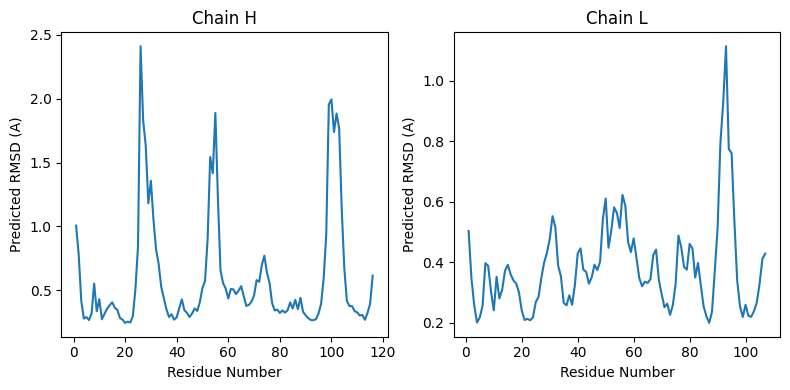

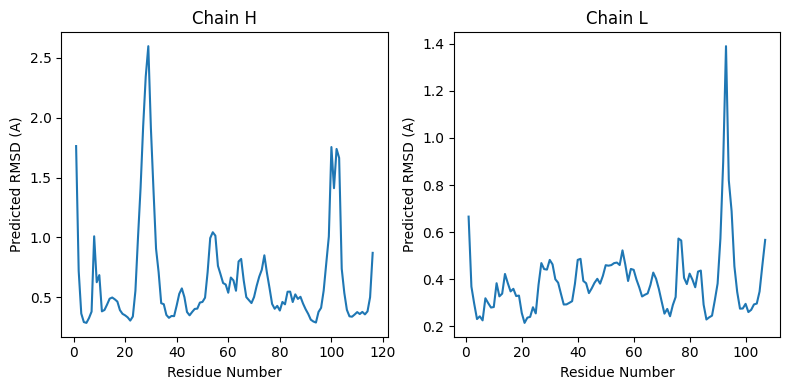

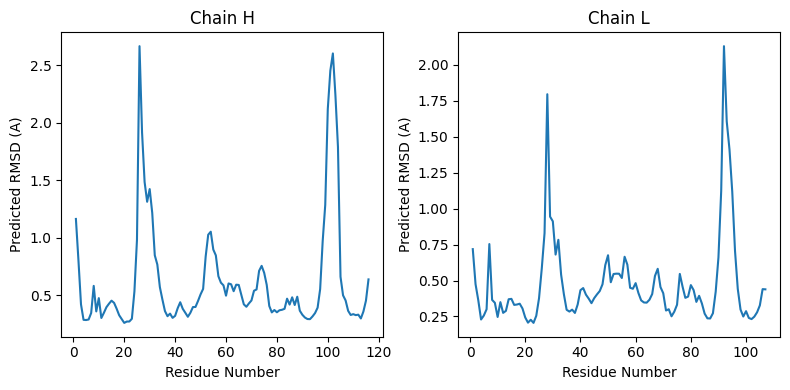

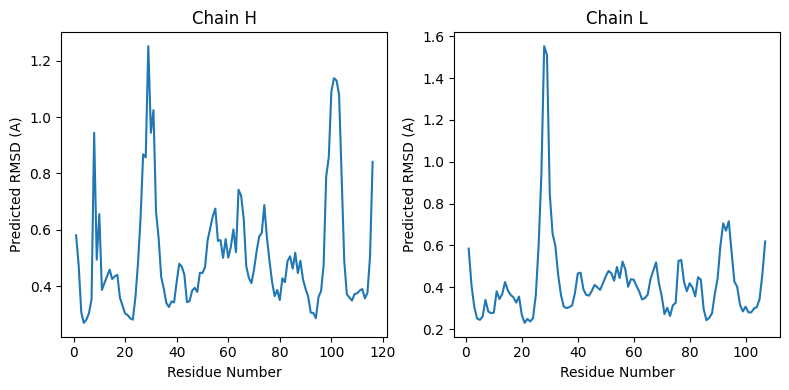

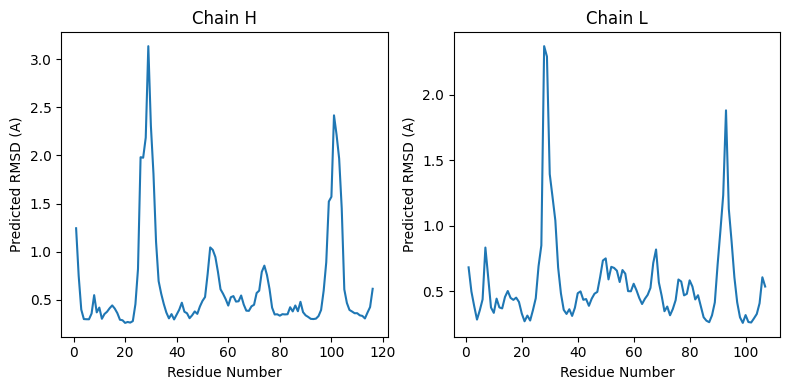

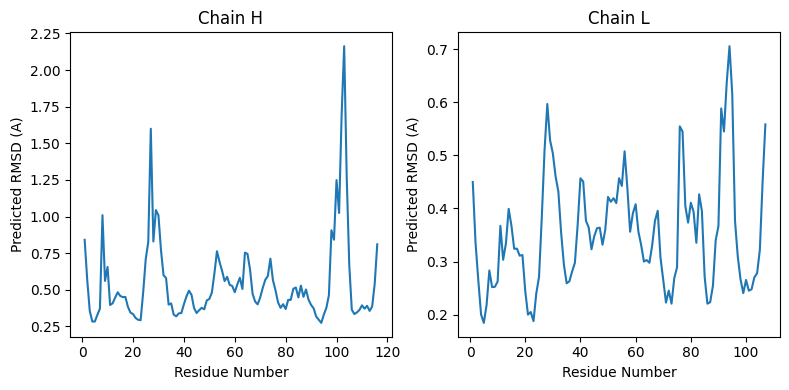

In [ ]:
for i in range(num_loops+1):
    H_seq,L_seq = run_a_loop(i)

Files are stored under the results folder. To download:

In [ ]:
from google.colab import files
!zip -r results.zip results/
files.download('results.zip')

  adding: results/ (stored 0%)
  adding: results/.ipynb_checkpoints/ (stored 0%)
  adding: results/pred2.fasta (deflated 33%)
  adding: results/pred0.pdb (deflated 78%)
  adding: results/pred_ori.pdb (deflated 78%)
  adding: results/prmsd3.png (deflated 10%)
  adding: results/pred4.pdb (deflated 78%)
  adding: results/prmsd2.png (deflated 9%)
  adding: results/pred0.fasta (deflated 33%)
  adding: results/prmsd4.png (deflated 8%)
  adding: results/prmsd_ori.png (deflated 9%)
  adding: results/pred3.fasta (deflated 33%)
  adding: results/pred3.pdb (deflated 78%)
  adding: results/prmsd1.png (deflated 10%)
  adding: results/pred1.fasta (deflated 33%)
  adding: results/prmsd0.png (deflated 10%)
  adding: results/pred2.pdb (deflated 78%)
  adding: results/pred1.pdb (deflated 78%)
  adding: results/pred4.fasta (deflated 33%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>